# Import Libaries

In [1]:
%%capture

!pip install einops
!pip install torchmetrics # for FID
!pip install torch-fidelity # for FID 

# imports
import math
import numpy as np
import time
import matplotlib.pyplot as plt
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import ConcatDataset
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips

from skimage.io import imread_collection

import einops
from einops import rearrange

from tqdm import tqdm

# Set device agnostic code
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Raise an error if the device is not 'cuda'
assert torch.zeros(1).to(device).device.type == 'cuda'

# Hyperparameters

In [2]:
# I try to add all hyperparameters in this block

iterations = 900000
batch_size = 64
T = 1000 # total noising time steps
#noise_schedule = 'linear'
noise_schedule = 'cosine'
lr = 3e-4 # learning rate for the optimiser 3e-4 pr 1e-4
t_dim = 256 # Embedding dimensions for t
num_heads = 4 # number of heads on MultiheadAttention
n = 10000 # hyperparameter for t embedding
dropout=0.0
weight = 3 # guidance weight
warm_up_iterations = 2000 # warm up iterations for EMA
rate = 0.995 # rate for EMA
p = 0.995 # dynamic thresholding ratio
num_classes = 11
img_size = 32 # images we generate will be in this size (don't change this as it won't work due to CUDA memory/architecture issues)
#dataset = 'cifar10' # images 32x32
img_size_cifar = 32
#dataset = 'stl10' # images 96x96
img_size_stl = 96
# ddpm paper used random horizontal flips, but we find that it doesn't improve performance here
comp_trans_cifar = torchvision.transforms.Compose([
#        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
comp_trans_stl = torchvision.transforms.Compose([
#        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomCrop(img_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Data Preprocessing

In [3]:
def change_labels(data):
    for i in range(len(data.labels)):
        if data.labels[i] == 1:
            data.labels[i] = 2
        elif data.labels[i] == 2:
            data.labels[i] = 1
        elif data.labels[i] == 6:
            data.labels[i] = 7
        elif data.labels[i] == 7:
            data.labels[i] = 10 
    return data

In [4]:
%%capture
"""
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# choose dataset, note that as we are generating new images we can use both the training and the testing datasets
if dataset == 'cifar10':
    train_dataset = torchvision.datasets.CIFAR10('cifar10_train', train=True, download=True, transform=comp_trans)
    test_dataset = torchvision.datasets.CIFAR10('cifar10_test', train=False, download=True, transform=comp_trans)

    data = ConcatDataset([train_dataset,test_dataset])
    data_loader = torch.utils.data.DataLoader(data, shuffle=True, batch_size=batch_size, drop_last=True) 
    
if dataset == 'stl10':
    train_dataset = torchvision.datasets.STL10('stl10_train', split='train', download=True, transform=comp_trans)
    #train_dataset = change_labels(train_dataset)
    
    test_dataset = torchvision.datasets.STL10('stl10_test', split='test', download=True, transform=comp_trans)
    #test_dataset = change_labels(test_dataset)

    data = ConcatDataset([train_dataset,test_dataset])
    data_loader = torch.utils.data.DataLoader(data, shuffle=True, batch_size=batch_size, drop_last=True)
    class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
#class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'monkey']     
train_iterator = iter(cycle(data_loader))    
"""

In [4]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# Load CIFAR-10, note that we can also use the testing data as we are generating images
train_dataset_cifar = torchvision.datasets.CIFAR10('cifar10_train', train=True, download=True, transform=comp_trans_cifar)
test_dataset_cifar = torchvision.datasets.CIFAR10('cifar10_test', train=False, download=True, transform=comp_trans_cifar)

# Load STL-10, change the labels so that it matches CIFAR-10's labels
train_dataset_stl = torchvision.datasets.STL10('stl10_train', split='train', download=True, transform=comp_trans_stl)
train_dataset_stl = change_labels(train_dataset_stl)
test_dataset_stl = torchvision.datasets.STL10('stl10_test', split='test', download=True, transform=comp_trans_stl)
test_dataset_stl = change_labels(test_dataset_stl)

# Concat all datasets and create a dataloader
data = ConcatDataset([train_dataset_cifar,train_dataset_stl,test_dataset_cifar,test_dataset_stl])
data_loader = torch.utils.data.DataLoader(data, shuffle=True, batch_size=batch_size, drop_last=True)

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'monkey']     
# train_iterator = iter(cycle(data_loader))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Diffusion Model:

## U-Net Architecture:

I follow closely code from https://github.com/dome272/Diffusion-Models-pytorch with Apache License 2.0.
I modify the code to fit our requirements. I also modify some changes from the original Guided Diffusion paper
https://github.com/openai/guided-diffusion/ with MIT License. For more details on the papers that were considered for the UNet architecture check the pdf report.

### U-Net Basic Building Blocks:

In [5]:
# We use a U-Net architecture, therefore we need some downsampling/upsampling blocks.
# We also implement self-attention and some residual connections. https://arxiv.org/abs/1706.03762
# Note we should add dropout somewhere and try that

class BaseBlock(nn.Module):
    """
    I denote convolution(k,s,p) as a convolution with kernel_size kxk, stride s and padding p
    A block that performs convolution(3,1,1) - groupnorm - gelu - convolution - groupnorm - gelu
    There is an option to add a residual connection before the last gelu

    :param in_channels: Input channels (C dimension of [B,C,H,W] image)
    :param mid_channels: Channels of the intermidiate convolution
    :param out_channels: Output channels
    :param residual: True if we want to have a residual connection on this block
    """

    def __init__(self, in_channels, mid_channels, out_channels, residual=False):
        super().__init__()
        self.residual = residual
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False), # bias default is true
            nn.GroupNorm(1, mid_channels), # as we are using transformers we prefer this rather than batchnorm
            nn.GELU(), # guided diffusion paper uses SiLU
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels))
        
    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x) #  NO GELU HERE
#            return self.double_conv(x)

class DownBlock(nn.Module):
    """
    A block that halves the W and H dimensions of the input
    It includes an embedding layer for t, that is then resized to the same dimensions as x so that we can add them
    The block performs for x:
    MaxPool - Convolution(3,1,1) - GroupNorm - GELU - Convolution(3,1,1) - GroupNorm - GELU - with a residual connection -
              Convolution(3,1,1) - GroupNorm - GELU - Convolution(3,1,1) - GroupNorm - GELU - Dropout
    The block performs for t:
    SiLU - Linear

    :param in_channels: Input channels for this block
    :param out_channels: Output channels for this block
    :param t_dim: Embedding dimensions for t
    """
    def __init__(self, in_channels, out_channels, dropout,t_dim=256):
        super().__init__()
        
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), # kernel size 2x2, stride 2 # guided diffusion used avgpool instead
            BaseBlock(in_channels, in_channels, in_channels, residual=True),
            BaseBlock(in_channels, in_channels, out_channels),
            nn.Dropout(p=dropout))
            

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_dim, out_channels))

    def forward(self,x,t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:,:,None,None].repeat(1,1,x.shape[2],x.shape[3]) # turn emb to the same dimension as x so that we can add them
        return (x + emb)

class UpBlock(nn.Module):
    """
    A block that doubles the W and H dimensions of the input
    It includes an embedding layer for t, that is then resized to the same dimensions as x so that we can add them
    The block performs for x:
    Upsample - Dropout - Convolution(3,1,1) - GroupNorm - GELU - Convolution(3,1,1) - GroupNorm - GELU - with a residual connection -
                         Convolution(3,1,1) - GroupNorm - GELU - Convolution(3,1,1) - GroupNorm - GELU - with mid_channels
    The block performs for t:
    SiLU - Linear

    :param in_channels: Input channels for this block (channels of x)
    :param out_channels: Output channels for this block
    :param t_dim: Embedding dimensions for t    
    """
    def __init__(self, in_channels, out_channels, dropout, t_dim=256):
        super().__init__()
        
        self.in_conv_channels = in_channels * 2 # as we concat x with the connection, their channels get added
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True) # guided diffusion paper uses F.interpolate
        
        self.convblock = nn.Sequential(
            nn.Dropout(p=dropout),
            BaseBlock(self.in_conv_channels, self.in_conv_channels, self.in_conv_channels, residual=True),
            BaseBlock(self.in_conv_channels, self.in_conv_channels // 2, out_channels))

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                t_dim,
                out_channels))

    def forward(self, x, connection, t):
        x = torch.cat([connection, self.up(x)], dim=1) # we concat x with the connection, i.e. the channels get added
        return self.convblock(x) + self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
    
class AttentionBlock(nn.Module):
    """
    Block that performs QKV attention
    First we pass x through a LayerNorm in order to get the Q,K,V values (which are the same)
    Then we get the attention value which we add to x, pass the output through a layer of:
    LayerNorm-Linear-GELU-Linear
    and finaly add to this the attention value once again.
    
    In order to perform these manipulations we need to get x to the same shape as the attention value (so they can be added)
    and then reshape it to it's initial dimensions. Note that this block does not change the dimensions of x.

    
    :param channels: Number of input channels
    :param num_heads: Number of heads for MultiheadAttention
    :param size: Size of the image
    """
    def __init__(self, channels, num_heads, size):
        super().__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, num_heads, batch_first=True)
        self.lin = nn.LayerNorm([channels])
        self.a_stack = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(), # can try SiLU I guess
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_lin = self.lin(x)
        attention, _ = self.mha(x_lin, x_lin, x_lin)
        attention = attention + x
        attention = (self.a_stack(attention) + attention)
        return attention.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

def encode_t(t, t_dim, n):
    """
    Following https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/
    Functions that turns t from [B] to [B,t_dim]
    
    :param t: Tensor of dimension of the batch size
    :param t_dim: Number of embedding dimensions for t
    :param n: Hyperparameter, tuned to 10,000 in https://arxiv.org/abs/1706.03762
    :return:
    """
    t = t.unsqueeze(-1)
    denominator = n ** (torch.arange(0, t_dim, step=2, device=device).float() / t_dim)
    enc_sin = torch.sin(t.repeat(1, t_dim // 2) / denominator)
    enc_cos = torch.cos(t.repeat(1, t_dim // 2) / denominator)
    return torch.cat([enc_sin, enc_cos], dim=1)

## Improvements

### Exponential Moving Average

In [6]:
def update_ema(ddpm, ema_ddpm, rate=rate):
    """
    Function that updates the parameters using exponential moving average
    
    :param ddpm: Model without EMA
    :param ema_ddpm: Model we want to update it's parameters using EMA
    :param rate: The EMA rate
    """
    
    for ddpm_params, ema_ddpm_params in zip(ddpm.parameters(), ema_ddpm.parameters()):
        ddpm_weights, ema_ddpm_weights = ddpm_params.data, ema_ddpm_params.data
        ema_ddpm_params.data = ema_ddpm_weights * rate + (1 - rate) * ddpm_weights
        

### Dynamic Thresholding

In [7]:
def dynamic_thresholding(x,p=p):
    """
    Dynamic thresholing algorithm from https://arxiv.org/pdf/2205.11487.pdf
    Implementation is adapted and modified from https://github.com/huggingface/diffusers/blob/v0.11.0/src/diffusers/schedulers/scheduling_dpmsolver_singlestep.py#L272
    
    :param x: Input tensor the function will perform dynamic thresholding to
    :param p: Dynamic thresholding ratio, set to 0.995 as in the paper and the code
    """
    # Seperate the color channels
    x_seperated = x.reshape((x.shape[0],-1))
    
    # Find the dynamic maximum values for each color channel
    dynamic_values = torch.quantile(torch.abs(x_seperated), p, dim=1)
    dynamic_values = torch.maximum(dynamic_values,torch.ones_like(dynamic_values)).unsqueeze(dim=1).unsqueeze(dim=1)
    
    # Perform dynamic thresholding according to the dynamic maximum values
    x = torch.clamp(x, -dynamic_values, dynamic_values) / dynamic_values
    return x

def batch_dynamic_thresholding(x,p=p):
    """
    Perform dynamic thresholding when x is of the form [B,C,H,W]
    
    :param x: Input tensor the function will perform dynamic thresholding to
    :param p: Dynamic thresholding ratio, set to 0.995 as in the paper and the code
    """
    
    for i in range(x.shape[0]):
        x[i] = dynamic_thresholding(x[i],p=p)
    return x

### Building the U-Net

In [8]:
# Tried building a deeoer U-Net. This one produced better results.

class UNet(nn.Module):
    def __init__(self,t_dim, num_classes=num_classes):
        super().__init__()
        self.t_dim = t_dim
        
        self.ch = nn.Embedding(num_classes, t_dim) 
        
        self.initial = BaseBlock(3,64,64,False) # for CIFAR-10 [Bx3x32x32] --> [Bx64x32x32]
        
        # Down
        self.down_block1 = DownBlock(64,128,dropout) # [Bx64x32x32] --> [Bx128x16x16]
        self.down_attention1 = AttentionBlock(128, num_heads, size=img_size//2) # attention block does not change the dimensions
        self.down_block2 = DownBlock(128,256,dropout) # [Bx128x16x16] --> [Bx256x8x8]
        self.down_attention2 = AttentionBlock(256, num_heads, size=img_size//4)
        self.down_block3 = DownBlock(256,256,dropout) # [Bx256x8x8] --> [Bx256x4x4]
        self.down_attention3 = AttentionBlock(256,num_heads, size=img_size//8)
        
        # Bottleneck, the dimensions of the input 
        self.bottle1 = BaseBlock(256,256,512,False)
        self.bottle2 = BaseBlock(512,512,512,False)
        self.bottle3 = BaseBlock(512,256,256,False)
        
        # Up
        self.up_block1 = UpBlock(256,128,dropout) # [Bx256x4x4] --> [Bx128x8x8]
        self.up_attention1 = AttentionBlock(128,num_heads, size=img_size//4)
        self.up_block2 = UpBlock(128,64,dropout) # [Bx128x8x8] --> [Bx64x16x16]
        self.up_attention2 = AttentionBlock(64,num_heads, size=img_size//2)
        self.up_block3 = UpBlock(64,32,dropout) # [Bx64x16x16] --> [Bx32x32x32]
        self.up_attention3 = AttentionBlock(32,num_heads, size=img_size)
        
        self.final = BaseBlock(32,32,3,False) # [Bx32x32x32] --> [Bx3x32x32]
        
    def forward(self, x, t, c=None):
        t = encode_t(t, t_dim, n) # turn t from [B] to [B,t_dim]
        
        if c != None:
            t += self.ch(c) # add the label embedding to the timestep embedding
        
        connection_1 = self.initial(x)
        
        # Down
        connection_2 = self.down_block1(connection_1,t)
        connection_2 = self.down_attention1(connection_2)
        
        connection_3 = self.down_block2(connection_2,t)
        connection_3 = self.down_attention2(connection_3)      

        x = self.down_block3(connection_3,t)
        x = self.down_attention3(x)
        
        # Bottleneck
        x = self.bottle1(x)
        x = self.bottle2(x)
        x = self.bottle3(x)
        
        # Down
        x = self.up_block1(x, connection_3, t)
        x = self.up_attention1(x)
        x = self.up_block2(x, connection_2, t)
        x = self.up_attention2(x)
        x = self.up_block3(x, connection_1, t)
        x = self.up_attention3(x)
        
        x = self.final(x)
        
        return x  

In [9]:
%%capture
# This block is only for reference as it produces worse results in comparison with the U-Net on the above cell
"""
class UNet(nn.Module):
    def __init__(self,t_dim, num_classes=num_classes):
        super().__init__()
        self.t_dim = t_dim
        
        self.ch = nn.Embedding(num_classes, t_dim) 
        
        self.initial = BaseBlock(3,64,64,False) # for CIFAR-10 [Bx3x32x32] --> [Bx64x32x32]
        
        # Down
        self.down_block1 = DownBlock(64,128,dropout) # [Bx64x32x32] --> [Bx128x16x16]
        self.down_attention1 = AttentionBlock(128, num_heads, size=img_size//2) # attention block does not change the dimensions
        self.down_block2 = DownBlock(128,256,dropout) # [Bx128x16x16] --> [Bx256x8x8]
        self.down_attention2 = AttentionBlock(256, num_heads, size=img_size//4)
        self.down_block3 = DownBlock(256,256,dropout) # [Bx256x8x8] --> [Bx256x4x4]
        self.down_attention3 = AttentionBlock(256,num_heads, size=img_size//8)
        self.down_block4 = DownBlock(256,256,dropout) # [Bx256x4x4] --> [Bx256x2x2]
        self.down_attention4 = AttentionBlock(256,num_heads, size=img_size//16)
        
        # Bottleneck, the dimensions of the input 
        self.bottle1 = BaseBlock(256,256,512,False)
        self.bottle2 = BaseBlock(512,512,512,False)
        self.bottle3 = BaseBlock(512,256,256,False)
        
        # Up
        self.up_block4 = UpBlock(256,256,dropout) # [Bx256x4x4] --> [Bx128x8x8]
        self.up_attention4 = AttentionBlock(256,num_heads, size=img_size//8)
        self.up_block1 = UpBlock(256,128,dropout) # [Bx256x4x4] --> [Bx128x8x8]
        self.up_attention1 = AttentionBlock(128,num_heads, size=img_size//4)
        self.up_block2 = UpBlock(128,64,dropout) # [Bx128x8x8] --> [Bx64x16x16]
        self.up_attention2 = AttentionBlock(64,num_heads, size=img_size//2)
        self.up_block3 = UpBlock(64,32,dropout) # [Bx64x16x16] --> [Bx32x32x32]
        self.up_attention3 = AttentionBlock(32,num_heads, size=img_size)
        
        self.final = BaseBlock(32,32,3,False) # [Bx32x32x32] --> [Bx3x32x32]
        
    def forward(self, x, t, c=None):
        t = encode_t(t, t_dim, n) # turn t from [B] to [B,t_dim]
        
        if c != None:
            t += self.ch(c) # add the label embedding to the timestep embedding
        
        connection_1 = self.initial(x)
        
        # Down
        connection_2 = self.down_block1(connection_1,t)
        connection_2 = self.down_attention1(connection_2)
        
        connection_3 = self.down_block2(connection_2,t)
        connection_3 = self.down_attention2(connection_3)  

        connection_4 = self.down_block3(connection_3,t)
        connection_4 = self.down_attention3(connection_4)

        x = self.down_block4(connection_4,t)
        x = self.down_attention4(x)
        
        # can add another block here
        
        # Bottleneck
        x = self.bottle1(x)
        x = self.bottle2(x)
        x = self.bottle3(x)
        
        # Down
        x = self.up_block4(x, connection_4, t)
        x = self.up_attention4(x) 
        x = self.up_block1(x, connection_3, t)
        x = self.up_attention1(x)
        x = self.up_block2(x, connection_2, t)
        x = self.up_attention2(x)
        x = self.up_block3(x, connection_1, t)
        x = self.up_attention3(x)
        
        x = self.final(x)
        
        return x  
"""

## Scheduling for the Diffusion

Initially I tried the simple linear beta schedule with endpoints 0.0001 and 0.02

In [10]:
def linear_noise_schedule(beta1=1e-4, beta2=0.02, T=T):
    beta_t = beta1 + (beta2-beta1) * torch.arange(0,T+1,dtype=torch.float32,device=device) / T # b_t is linear increaments from 10^(-4) to 0.02
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t) # take the log so that we can compute bar{a_t} easier (in log form we just add, instead of multiply)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp() # take the exponent, since we took the log before
    return alphabar_t, beta_t, alpha_t

I also tried the cosine noise schedule from https://arxiv.org/pdf/2102.09672.pdf

In [11]:
def cosine_noise_schedule(T=T, s=0.008):
    t = torch.arange(0,T+1,dtype=torch.float32) / T
    alphabar_t = np.cos((t + s) / (1 + s)* np.pi / 2) ** 2
    alphabar_t_minus_1 = (torch.cat((torch.tensor(1.0).unsqueeze(dim=0),alphabar_t)))[0:(T+1)]
    beta_t = 1 - alphabar_t/alphabar_t_minus_1
    beta_t = beta_t.clamp(0,0.999)
    return alphabar_t, beta_t

In [12]:
if noise_schedule == 'linear':
    alphabar_t, beta_t, alpha_t = linear_noise_schedule()
    
elif noise_schedule == 'cosine':
    alphabar_t, beta_t = cosine_noise_schedule()
    alpha_t = 1 - beta_t
    
alphabar_t, beta_t, alpha_t = alphabar_t.to(device), beta_t.to(device), alpha_t.to(device)    
    
sqrtab = torch.sqrt(alphabar_t).view(-1,1,1,1) # reshape it so that we can multiply it with x
sqrtmab = torch.sqrt(1-alphabar_t).view(-1,1,1,1)

oneover_sqrta = 1/torch.sqrt(alpha_t)
mab_over_sqrtmab_inv = (1-alpha_t)/sqrtmab.squeeze()

# values for sigma
sigma_t = torch.sqrt(beta_t)

## Diffusion Model:

In [86]:
class DDPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = UNet(t_dim,num_classes).to(device)
    
    def forward(self,x,c):
        _ts = torch.randint(1, T+1, (x.shape[0],)).to(device)
        eps = torch.randn_like(x)
        x_t = sqrtab[_ts] * x + sqrtmab[_ts] * eps
        return F.mse_loss(eps, self.net(x_t, _ts, c)) # loss between actual noise and the output of the net when we input our noised input 

    def sample(self,n_sample,size,c,weight=weight):
        
        if c is not None:
            c = c.to(device)
        
        x_t = torch.randn(n_sample, *size).to(device)

        for t in range(T,0,-1):
            if t > 1:
                z = torch.randn(n_sample,*size).to(device)
            else: 
                z = 0
            net_eps = self.net(x_t,torch.tensor(t).to(device),c)
            if weight > 0:
                unconditional_eps = self.net(x_t,torch.tensor(t).to(device))
                net_eps = torch.lerp(unconditional_eps, net_eps, weight)
            x_t = oneover_sqrta[t]*(x_t-mab_over_sqrtmab_inv[t]*net_eps) + sigma_t[t]*z
            
            # dynamic thresholding for x_t
            x_t = batch_dynamic_thresholding(x_t)
        return x_t

ddpm = DDPM().to(device)
ema_ddpm = copy.deepcopy(ddpm).eval().requires_grad_(False) # copy the model so we can use EMA

Define the optimiser. According to the literature (Guided Diffusion paper) AdamW performes better. We check this.

In [87]:
optim = torch.optim.AdamW(ddpm.parameters(), lr=lr)

# Load the Model

In [117]:
params = torch.load('final1.chkpt')
ddpm.load_state_dict(params['ddpm'])
ema_ddpm.load_state_dict(params['ema_ddpm'])
optim.load_state_dict(params['optimiser'])
epoch = params['epoch']

# Train the Model

In [15]:
epoch = 0

In [116]:
ddpm.train() # training mode
if epoch == 0:
    first = True # in the first epoch before some warm up iterations the two models are the same
else:
    first = False
    
while epoch<700:
    pbar = tqdm(data_loader)
    for i, (x, c) in enumerate(pbar):
        x = x.to(device)
        c = c.to(device)
        if torch.rand(1) < 0.1: # 10% of the time we train unconditionally
            c = None

        loss = ddpm(x,c)
        optim.zero_grad()
        loss.backward()
        optim.step()
        #update_ema(ddpm, ema_ddpm)
        #"""   
        if i < warm_up_iterations and first:
            ema_ddpm.load_state_dict(ddpm.state_dict())
        else:
            update_ema(ddpm, ema_ddpm)
            first = False
        #"""        
        pbar.set_postfix(MSE=loss.item())

    if epoch % 10 == 0:
        with torch.inference_mode():
            xh = ema_ddpm.sample(10,(3, img_size, img_size),c=torch.tensor(0))
            img_grid = rearrange(torch.cat([(xh*0.5+0.5), (x*0.5+0.5)[:10]], dim=0), '(b1 b2) c h w -> (b1 h) (b2 w) c', b1=2)
            plt.figure(figsize=(32, 32))
            plt.imshow((img_grid.cpu()*255).int().numpy())
            plt.show()
        
    epoch += 1

  0%|          | 3/1140 [00:02<13:48,  1.37it/s, MSE=0.0518]


KeyboardInterrupt: 

# Save the Model

In [18]:
torch.save({'ddpm':ddpm.state_dict(), 'ema_ddpm':ema_ddpm.state_dict(), 'optimiser':optim.state_dict(), 'epoch':epoch}, 'final1.chkpt')

# Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


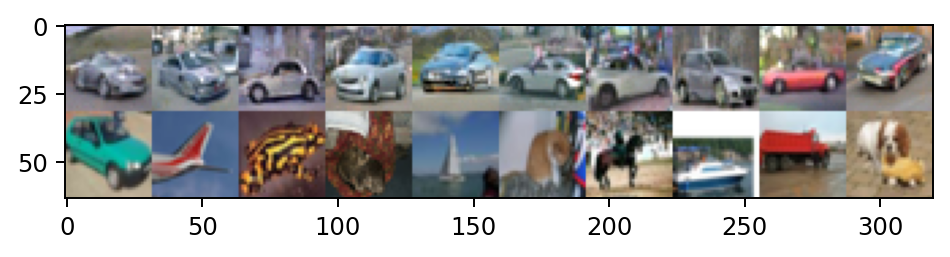

In [120]:
# Choose the type of image you want to visualise
c = torch.tensor(1)

ema_ddpm.eval()
plt.rcParams['figure.dpi'] = 175
with torch.inference_mode():
    xh = ema_ddpm.sample(10,(3, img_size, img_size),c=c)
    img_grid = rearrange(torch.cat([(xh+0.5), (x*0.5+0.5)[:10]], dim=0), '(b1 b2) c h w -> (b1 h) (b2 w) c', b1=2)
    plt.imshow((img_grid.cpu()*255).int().numpy())

torch.Size([2, 3, 32, 32])
torch.Size([3, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([5, 3, 32, 32])
torch.Size([6, 3, 32, 32])
torch.Size([7, 3, 32, 32])
torch.Size([8, 3, 32, 32])
torch.Size([9, 3, 32, 32])
torch.Size([10, 3, 32, 32])
torch.Size([11, 3, 32, 32])
torch.Size([12, 3, 32, 32])
torch.Size([13, 3, 32, 32])
torch.Size([14, 3, 32, 32])
torch.Size([15, 3, 32, 32])
torch.Size([16, 3, 32, 32])
torch.Size([17, 3, 32, 32])
torch.Size([18, 3, 32, 32])
torch.Size([19, 3, 32, 32])
torch.Size([20, 3, 32, 32])
torch.Size([21, 3, 32, 32])
torch.Size([22, 3, 32, 32])
torch.Size([23, 3, 32, 32])
torch.Size([24, 3, 32, 32])
torch.Size([25, 3, 32, 32])
torch.Size([26, 3, 32, 32])
torch.Size([27, 3, 32, 32])
torch.Size([28, 3, 32, 32])
torch.Size([29, 3, 32, 32])
torch.Size([30, 3, 32, 32])
torch.Size([31, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([33, 3, 32, 32])
torch.Size([34, 3, 32, 32])
torch.Size([35, 3, 32, 32])
torch.Size([36, 3, 32, 32])
torch.Size([37, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])


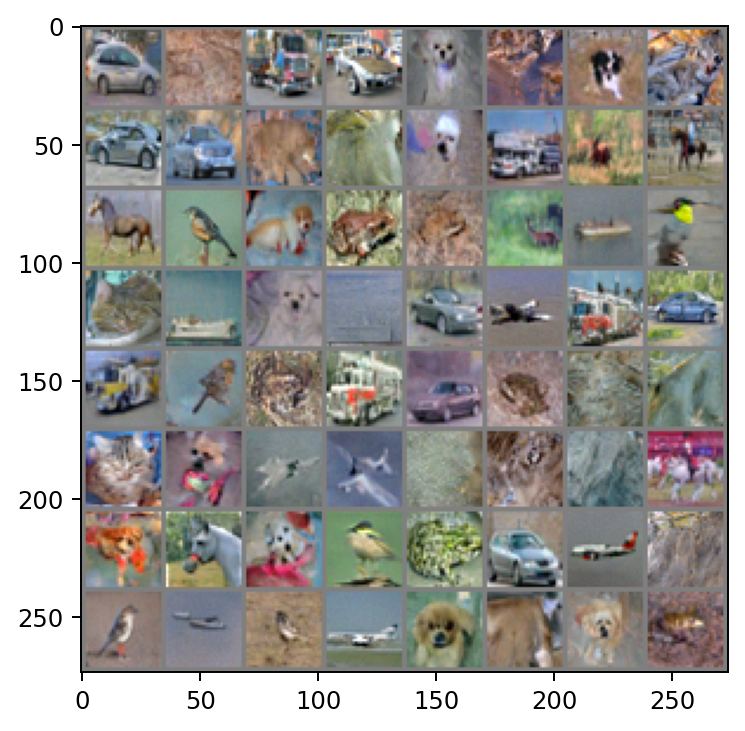

In [107]:
# Sample 64 non chery-picked images

ema_ddpm.eval()
with torch.inference_mode():
    for i in range(64):
        if i == 0:
            non_cherry = ema_ddpm.sample(1,(3, 32, 32),c=torch.randint(num_classes,(1,))[0]).cpu()
        else:
            new_img = ema_ddpm.sample(1,(3, 32, 32),c=torch.randint(num_classes,(1,))[0]).cpu()
            non_cherry = torch.cat((non_cherry, new_img))
            print(non_cherry.shape)
            
non_cherry_grid = torchvision.utils.make_grid(non_cherry)

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow((non_cherry_grid.permute(1,2,0))+0.5)
plt.show()

In [108]:
def x_to_image(x,c):
    """
    Function that takes an initial noise and turns it into an image.
    :param x: Initial noise to be turned into an image
    :param c: Class of the image we are going to turn it into
    """
    for t in range(T,0,-1):
        if t > 1:
            z = torch.randn((1,3,32,32)).to(device)
        else:
            z = 0
        net_eps = ema_ddpm.net(x,torch.tensor(t).to(device),c)
        if weight > 0:
            unconditional_eps = ema_ddpm.net(x,torch.tensor(t).to(device))
            net_eps = torch.lerp(unconditional_eps, net_eps, weight)
        
        x = oneover_sqrta[t]*(x-mab_over_sqrtmab_inv[t]*net_eps) + sigma_t[t]*z
        x = batch_dynamic_thresholding(x)
    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


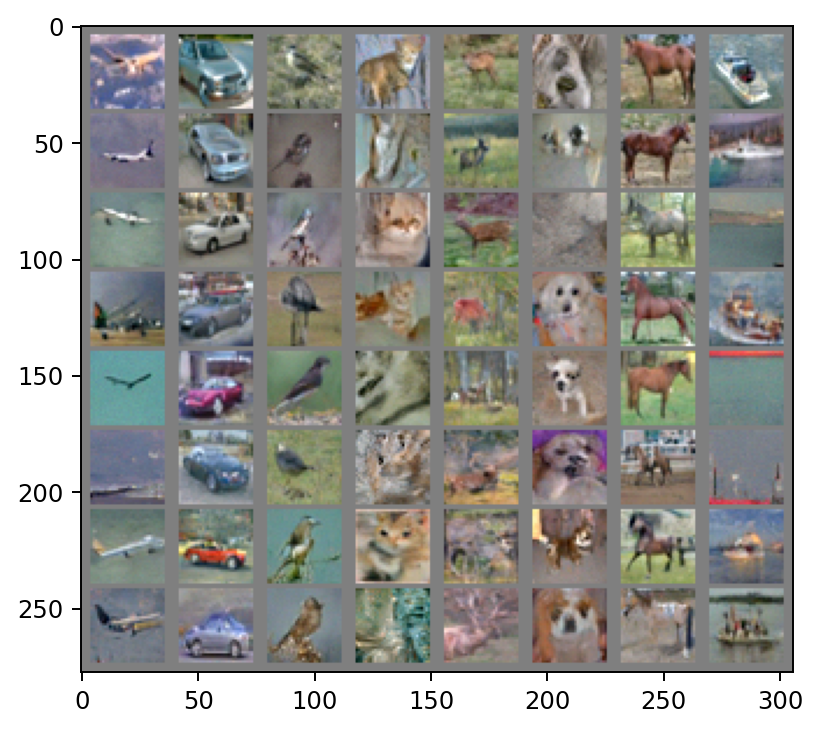

In [110]:
# Interpolations for 8 pairs of my sample
# We choose 8 labels that were trained using both datasets

ema_ddpm.eval()
with torch.inference_mode():
    labels = [0,1,2,3,4,5,7,8]
    times = torch.linspace(0,1,8).to(device)
    for label in labels:
            label = torch.tensor(label).to(device)
            x_1 = torch.randn((1,3,32,32)).to(device)
            x_8 = torch.randn((1,3,32,32)).to(device)

            x_2 = torch.lerp(x_1,x_8,times[1])
            x_3 = torch.lerp(x_1,x_8,times[2])
            x_4 = torch.lerp(x_1,x_8,times[3])
            x_5 = torch.lerp(x_1,x_8,times[4])
            x_6 = torch.lerp(x_1,x_8,times[5])
            x_7 = torch.lerp(x_1,x_8,times[6]) 

            new_column = x_to_image(x_1,label).cpu()

            for x in [x_2,x_3,x_4,x_5,x_6,x_7,x_8]:
                lerp_image = x_to_image(x,label).cpu()
                new_column = torch.cat((new_column, lerp_image))

            new_column = torchvision.utils.make_grid(new_column,nrow=1).unsqueeze(0)
            if label == torch.tensor(0):
                interpolations = new_column
            else:
                interpolations = torch.cat((interpolations, new_column))
    interpolations = torchvision.utils.make_grid(interpolations)

plt.rcParams['figure.dpi'] = 175
plt.grid(False)
plt.imshow((interpolations.permute(1,2,0))+0.5)
plt.show()

# Evaluate the Model

## Evaluation Functions

In order to evaluate the images we use Frechet Inception Distance. We have a reference batch of images, so that our results are more robust. We use the 100 images in the reference batch and 100 generated images. Note 

In [121]:
folder = 'real_images/*.png'
real_images_collection = imread_collection(folder)

np_to_tensor = transforms.ToTensor()

for i in range(len(real_images_collection)):
    if i == 0:
        real_images_tensor = np_to_tensor(real_images_collection[i]).unsqueeze(dim=0)
    else:
        real_images_tensor = torch.cat((real_images_tensor, np_to_tensor(real_images_collection[i]).unsqueeze(dim=0)))

real_images_fid = (real_images_tensor*255).to(torch.uint8) # turn images from the range [0,1] to [0,255]
normaliser = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
real_images_lpips = normaliser(real_images_tensor)
real_images_fid.shape, real_images_lpips.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100, 3, 32, 32]))

In case we want to load images we have generated beforehand we run the following cell.
In case we want to generate new images we run the cell below that.

In [122]:
folder = 'generated_images/*.png'
generated_images_collection = imread_collection(folder)

np_to_tensor = transforms.ToTensor()

for i in range(len(real_images_collection)):
    if i == 0:
        generated_images_tensor = np_to_tensor(generated_images_collection[i]).unsqueeze(dim=0)
    else:
        generated_images_tensor = torch.cat((generated_images_tensor, np_to_tensor(generated_images_collection[i]).unsqueeze(dim=0)))

generated_images_fid = (generated_images_tensor*255).to(torch.uint8) # turn images from the range [0,1] to [0,255]
normaliser = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
generated_images_lpips = normaliser(generated_images_tensor)
generated_images_fid.shape, generated_images_lpips.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100, 3, 32, 32]))

In [19]:
# Generate 100 images
ema_ddpm.eval()
with torch.inference_mode():
    for i in tqdm(range(100)):
        if i == 0:
            generated_images = ema_ddpm.sample(1,(3, img_size, img_size),c=torch.randint(num_classes,(1,))[0])
        else:
            new_image = ema_ddpm.sample(1,(3, img_size, img_size),c=torch.randint(num_classes,(1,))[0])
            generated_images = torch.cat((generated_images, new_image))
    
# Make sure the image is within the right range      
assert torch.min(generated_images) >= -1
assert torch.max(generated_images) <= 1

generated_images_to_save = (generated_images * 0.5) + 0.5
generated_images_fid = (generated_images * 255).to(torch.uint8).cpu()
generated_images_lpips = generated_images.cpu()

100%|██████████| 100/100 [33:44<00:00, 20.25s/it]


In [123]:
# Randomly shaffle the images in the batch of the 100 images we have generated

rng = np.random.default_rng()
generated_images_lpips_2 = generated_images_lpips.cpu().numpy().copy()
rng.shuffle(generated_images_lpips_2, axis=0) # axis=0 makes sure we shuffle the images and not the color channels or anything else
generated_images_lpips_2 = torch.from_numpy(generated_images_lpips_2) 

In [124]:
fid = FrechetInceptionDistance(feature=64)

fid.update(real_images_fid, real=True) # real images
fid.update(generated_images_fid, real=False) # generated images
print(fid.compute())
fid.reset()

tensor(12.4948)


In [125]:
loss_fn = lpips.LPIPS(net='alex')
d = loss_fn.forward(generated_images_lpips, generated_images_lpips_2) # here arguments of forward need to be in the range [-1,+1], shape [N,3,H,W]
print(d.mean().item())

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home2/cdxc13/myjupyterenv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home2/cdxc13/myjupyterenv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home2/cdxc13/myjupyterenv/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
0.06072993203997612


## Save Images

In [21]:
for i in range(generated_images.shape[0]):
    torchvision.utils.save_image(generated_images_to_save[i],'generated_images/' + str(i) + '.png') # save_image takes images in the range [0,1]